# Simulazione Real Environment MDP

## Drive & Environment Setting

In [133]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

#from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import sub2ind, ind2sub


import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
Libraries imported


## Import Anagrafica & CTA

In [102]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

#cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
#cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
#cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
#cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
#cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')
#CTA30_18 = [cta30_18_path]
#CTA30_19 = [cta30_19_path]
#CTA30_20 = [cta30_20_path]
#CTA30_21 = [cta30_21_path]
#CTA30_22 = [cta30_22_path]

#df18= pd.read_csv(CTA30_18[0])
#df19= pd.read_csv(CTA30_19[0])
#df20= pd.read_csv(CTA30_20[0])
#df21= pd.read_csv(CTA30_21[0])
#df22= pd.read_csv(CTA30_22[0])
#df = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

cta30_partitioned = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')
CTA30_partitioned = [cta30_partitioned]
df = pd.read_csv(CTA30_partitioned[0])
df_standard = df.drop(['Cluster','a1_discrete','a2_discrete','a3_discrete'], axis=1)

#df['VLV_RAF_REG_00'] = df['VLV_RAF_REG_00'] / 100
#df['VLV_SUR_REG_00'] = df['VLV_SUR_REG_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_REG_00'] * 0.5
a_sur_df = df['VLV_SUR_REG_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

#cta_pca = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/pca_df_clustered_partitioned.csv')
#CTA_pca = [cta_pca]
pca_df = compress_2(df_standard, 0.93)

[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)

df shape:  (2176378, 80)
pca_df shape:  (2176378, 9)


## Clustering & MDP Preparation

### Discretizzazione azioni

In [81]:
# Trova il valore più vicino dal basso per ogni azione
def valore_piu_vicino(lista, x):
    if x <= lista[0]:
        return lista[0]
    if x >= lista[-1]:
        return lista[-1]
    
    left = 0
    right = len(lista) - 1
    
    while left <= right:
        mid = (left + right) // 2
        
        if lista[mid] == x:
            return lista[mid]
        elif lista[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    
    if abs(lista[left] - x) < abs(lista[right] - x):
        return lista[left]
    else:
        return lista[right]

# Aggiungi un ultimo step agli intervalli di discretizzazione, così da considerare il valore massimo
def discretize_actions(min_value, max_value, num, upper):
    ret = np.linspace(min_value, max_value, num=num)
    if upper == True:
        step = ret[1] - ret[0]
        # add to last element step + ret[-1]
        ret = np.append(ret, step + ret[-1])
    return ret

In [84]:
#df['a1_discrete'] = None
#df['a2_discrete'] = None
#df['a3_discrete'] = None

[S, features] = df.shape

n_a1 = 15
n_a2 = 9
n_a3 = 9

a1_intervals = discretize_actions(df['F_M_FDBK_00'].min(), df['F_M_FDBK_00'].max(), num=n_a1, upper=True)
a2_intervals = discretize_actions(0, 1, num=n_a2, upper=True)
a3_intervals = discretize_actions(0, 1, num=n_a3, upper=True)

print("a1_intervals:", a1_intervals)
print("a2_intervals:", a2_intervals)
print("a3_intervals:", a3_intervals)

a1_intervals: [  0.           7.16708571  14.33417143  21.50125714  28.66834286
  35.83542857  43.00251429  50.1696      57.33668571  64.50377143
  71.67085714  78.83794286  86.00502857  93.17211429 100.3392
 107.50628571]
a2_intervals: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125]
a3_intervals: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125]


In [91]:
#for i in range(S):
    #ret1 = valore_piu_vicino(a1_intervals, df.loc[i,'F_M_FDBK_00'])
    #df.loc[i,'a1_discrete'] = ret1

    #ret2 = valore_piu_vicino(a2_intervals, df.loc[i,'VLV_RAF_REG_00'])
    #df.loc[i,'a2_discrete'] = ret2

    #ret3 = valore_piu_vicino(a3_intervals, df.loc[i,'VLV_SUR_REG_00'])
    #df.loc[i,'a3_discrete'] = ret3


#### Graphical Model - Action

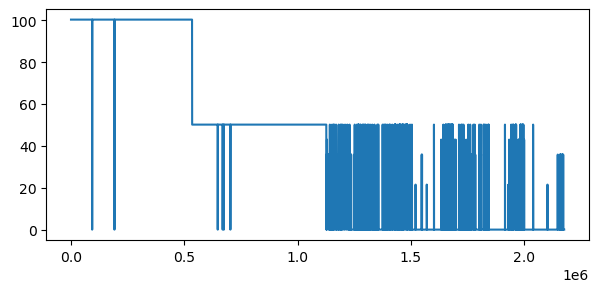

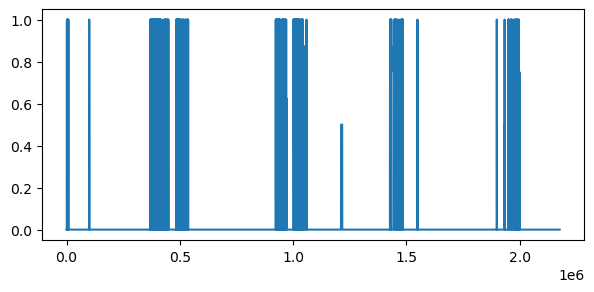

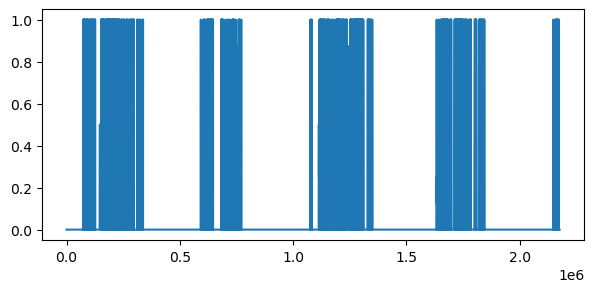

In [94]:
# plot values of a bin graphic of a1_discrete
plt.figure(figsize=(7,3))
plt.plot(df['a1_discrete'])
plt.show()

# plot values of a bin graphic of a2_discrete
plt.figure(figsize=(7,3))
plt.plot(df['a2_discrete'])
plt.show()

# plot values of a bin graphic of a3_discrete
plt.figure(figsize=(7,3))
plt.plot(df['a3_discrete'])
plt.show()


#### Actions Array (ind2sub)

In [ ]:
n_a1 = len(a1_intervals)
n_a2 = len(a2_intervals)
n_a3 = len(a3_intervals)

print("n_a1:", n_a1)
print("n_a2:", n_a2)
print("n_a3:", n_a3)

n_A = n_a1*n_a2*n_a3
print("numero azioni: ", n_A)

actions = np.zeros((n_A, 3))
for i in range (n_A):
    [a1, a2, a3] = ind2sub((n_a1, n_a2, n_a3), i)
    actions[i,0] = a1_intervals[a1]
    actions[i,1] = a2_intervals[a2]
    actions[i,2] = a3_intervals[a3]

print("actions: ",actions)
print("actions shape: ",actions.shape)

#### Save (no Cluster)

In [135]:
# save new df on cvs as df_clustered_partitioned.csv
#df['Cluster'] = None
#df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv'), index=False)
# save pca_df on cvs as pca_df_clustered_partitioned.csv
#pca_df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/pca_df_clustered_partitioned.csv'), index=False)

#save actions as array
#np.save(os.path.join(PROJECT_PATH, 'MDP_data/actions.npy'), actions)

### Clustering

In [103]:
campioni = [8, 10, 15, 22, 30]
cluster_group = []
for i in campioni:
    n_cluster = i
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(pca_df)
    cluster_group.append(kmeans.labels_)

cluster_group_df = pd.DataFrame(cluster_group)
cluster_group_df = cluster_group_df.transpose()
cluster_group_df.shape
cluster_group_df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/cluster_group_df.csv'), index=False)
cluster_group_df.columns = ['Cluster_8', 'Cluster_10', 'Cluster_15', 'Cluster_22', 'Cluster_30']


In [137]:
cluster_group_df['Cluster_8'].max()

7

#### Grapich Distribution - Clusters

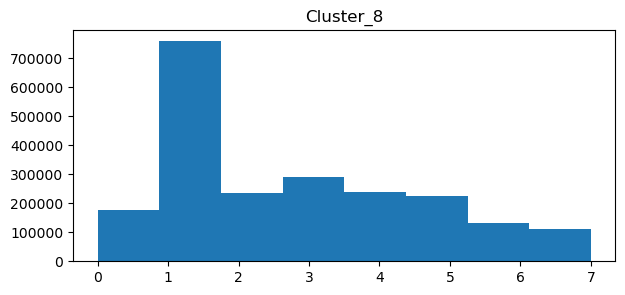

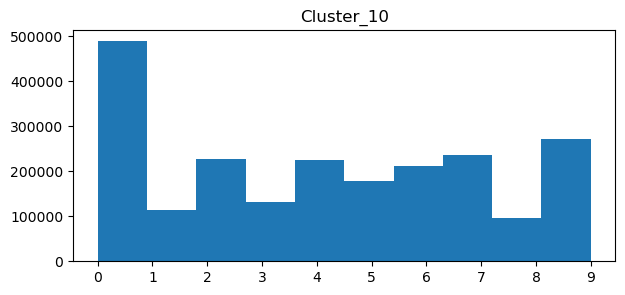

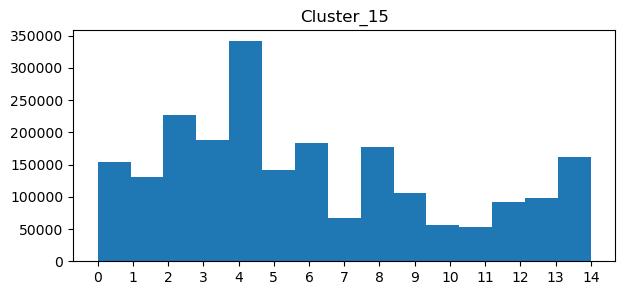

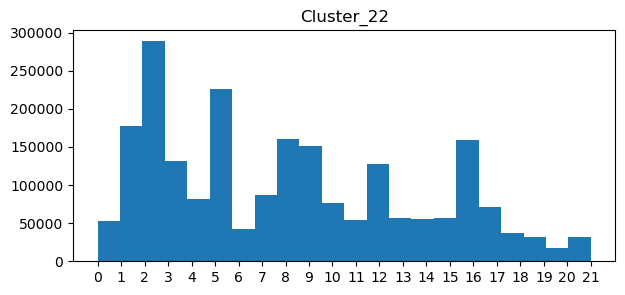

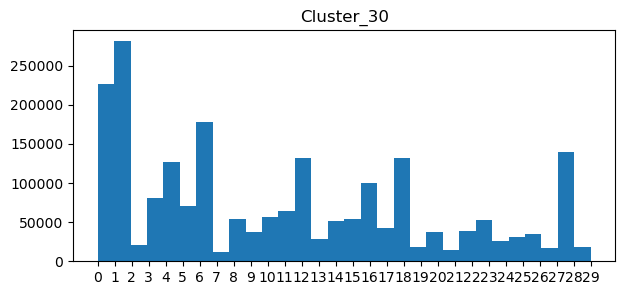

In [128]:
frequenze = cluster_group_df['Cluster_8'].value_counts().values
etichette = cluster_group_df['Cluster_8'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=8, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_8")
plt.show()

frequenze = cluster_group_df['Cluster_10'].value_counts().values
etichette = cluster_group_df['Cluster_10'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=10, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_10")
plt.show()

frequenze = cluster_group_df['Cluster_15'].value_counts().values
etichette = cluster_group_df['Cluster_15'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=15, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_15")
plt.show()

frequenze = cluster_group_df['Cluster_22'].value_counts().values
etichette = cluster_group_df['Cluster_22'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=22, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_22")
plt.show()

frequenze = cluster_group_df['Cluster_30'].value_counts().values
etichette = cluster_group_df['Cluster_30'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=30, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_30")
plt.show()


#### Probabilità Azioni

In [143]:
df.loc[1000000:1000300,'a1_discrete']

1000000    50.1696
1000001    50.1696
1000002    50.1696
1000003    50.1696
1000004    50.1696
            ...   
1000296    50.1696
1000297    50.1696
1000298    50.1696
1000299    50.1696
1000300    50.1696
Name: a1_discrete, Length: 301, dtype: float64

In [144]:
total_probability = []

for clust in cluster_group_df.columns:

    df[clust] = cluster_group_df[clust]
    n_cluster = cluster_group_df[clust].max() + 1

    for a1 in a1_intervals:
        # count how many times a appears in every cluster in df and compute the probability of a in every cluster. return a list of probabilities
        prob_a1 = []
        for i in range(n_cluster):
            prob_a1.append(df.loc[df[clust] == i, 'a1_discrete'].value_counts(normalize=True).get(a1, 0))
        
    for a2 in a2_intervals:
        # count how many times a appears in every cluster in df and compute the probability of a in every cluster. return a list of probabilities
        prob_a2 = []
        for i in range(n_cluster):
            prob_a2.append(df.loc[df[clust] == i, 'a2_discrete'].value_counts(normalize=True).get(a2, 0))
    
    for a3 in a3_intervals:
        # count how many times a appears in every cluster in df and compute the probability of a in every cluster. return a list of probabilities
        prob_a3 = []
        for i in range(n_cluster):
            prob_a3.append(df.loc[df[clust] == i, 'a3_discrete'].value_counts(normalize=True).get(a3, 0))
    
    total_probability.append([prob_a1, prob_a2, prob_a3])


# save total_probability as array
np.save(os.path.join(PROJECT_PATH, 'MDP_data/total_probability.npy'), total_probability)




In [ ]:
total_probability_a1 = np.zeros((n_cluster, n_a1))
for i in range(n_cluster):

    # sottinsieme di df con cluster i
    cluster_data = df[df['Cluster'] == i]

    # numero di elementi nel cluster i
    cluster_count = len(cluster_data)
    for j in a1_intervals:
        
        total_probability_a1[i, j] = len(df[(df['Cluster'] == i) & (df['a1_discrete'] == j)]) / len(df[df['Cluster'] == i])


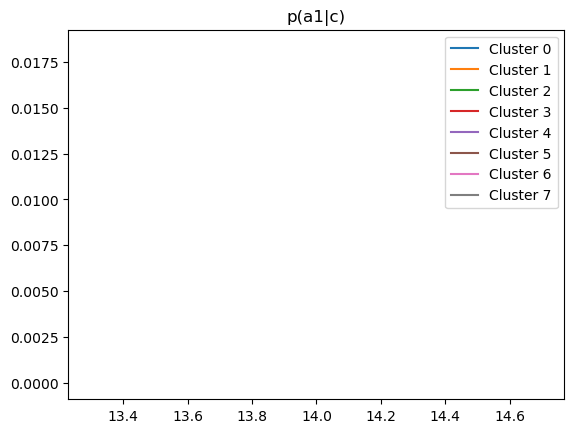

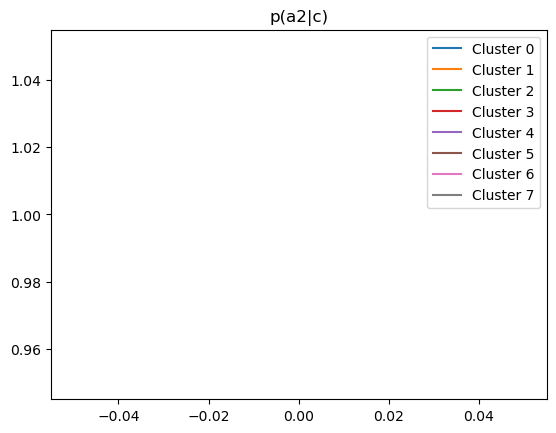

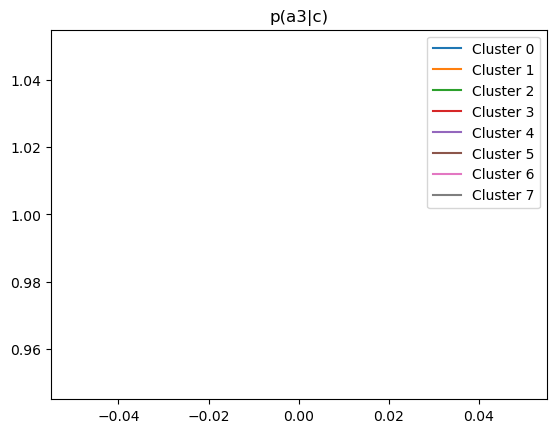

In [65]:
total_counts_a1 = []
for i in range(n_cluster):
    counts = df.loc[df['Cluster'] == i, 'a1_discrete'].value_counts(dropna=False)
    total_counts_a1.append([counts])

total_counts_a2 = []
for i in range(n_cluster):
    counts = df.loc[df['Cluster'] == i, 'a2_discrete'].value_counts()
    total_counts_a2.append([counts])

total_counts_a3 = []
for i in range(n_cluster):
    counts = df.loc[df['Cluster'] == i, 'a3_discrete'].value_counts()
    total_counts_a3.append([counts])


p_a1 = []
for i in range(n_cluster):
    p_a1.append(total_counts_a1[i][0] / total_counts_a1[i][0].sum())

p_a2 = []
for i in range(n_cluster):
    p_a2.append(total_counts_a2[i][0] / total_counts_a2[i][0].sum())

p_a3 = []
for i in range(n_cluster):
    p_a3.append(total_counts_a3[i][0] / total_counts_a3[i][0].sum())

#plot p(a1|c)
for i in range(n_cluster):
    plt.plot(p_a1[i], label='Cluster '+str(i))
plt.legend()
plt.title('p(a1|c)')
plt.show()

#plot p(a2|c)
for i in range(n_cluster):
    plt.plot(p_a2[i], label='Cluster '+str(i))
plt.legend()
plt.title('p(a2|c)')
plt.show()

#plot p(a3|c)
for i in range(n_cluster):
    plt.plot(p_a3[i], label='Cluster '+str(i))
plt.legend()
plt.title('p(a3|c)')
plt.show()

#plot p(c)
p_c = df['Cluster'].value_counts() / df['Cluster'].value_counts().sum()


#plot p(a1)
p_a1 = df['a1_discrete'].value_counts() / df['a1_discrete'].value_counts().sum()


#plot p(a2)
p_a2 = df['a2_discrete'].value_counts() / df['a2_discrete'].value_counts().sum()


#plot p(a3)
p_a3 = df['a3_discrete'].value_counts() / df['a3_discrete'].value_counts().sum()






#### Matrice di Transizione

In [36]:
T = np.zeros((n_cluster, n_cluster, n_A))

for i1 in range(n_cluster):
    for i2 in range(n_cluster):
        for i3 in range(n_A):
            [a1, a2, a3] = ind2sub((n_a1, n_a2, n_a3), i3)
            try:
                T[i1, i2, i3] = p_a1[i1][a1] * p_a2[i2][a2] * p_a3[i2][a3]
            except:
                T[i1, i2, i3] = 0



#### Matrice dei Reward

In [59]:
total_counts_a1

[[0    218686
  5     13949
  6      6520
  7      4353
  3      2343
  4       550
  1         8
  2         4
  Name: a1_discrete, dtype: int64],
 [14    185122
  7      41354
  0         51
  Name: a1_discrete, dtype: int64],
 [0     437356
  7     194573
  5      74150
  14     32315
  6      11910
  4       7711
  3       1114
  2         31
  1         29
  Name: a1_discrete, dtype: int64],
 [0     196026
  7      52884
  5        688
  3        434
  6        125
  4        125
  14        54
  1          4
  2          2
  Name: a1_discrete, dtype: int64],
 [7     179354
  0      20899
  14     18082
  5       2977
  4       2636
  6        107
  3         64
  Name: a1_discrete, dtype: int64],
 [14    102553
  7      27567
  0       1367
  3          1
  Name: a1_discrete, dtype: int64],
 [14    121451
  7      56404
  0         96
  3          1
  Name: a1_discrete, dtype: int64],
 [14    74537
  7     50282
  4     19540
  5     10403
  6      4304
  3      1276
  2         

In [58]:

R = np.zeros((n_cluster, n_A))

cluster_rewards = []
cluster_sums = []
cluster_means = []

for i in range(n_cluster):
    cluster_data = df[df['Cluster'] == i]
    cluster_sum = cluster_data['PW_ATT_M_00'].sum()
    cluster_mean = cluster_data['PW_ATT_M_00'].mean()
    cluster_sums.append(cluster_sum)
    cluster_means.append(cluster_mean)


df_clusters = {
    'Cluster': range(n_cluster),
    'Sum': cluster_sums,
    'PW Mean': cluster_means,
    'p(a1)': p_a1,
    'p(a2)': p_a2,
    'p(a3)': p_a3
}

df_clusters = pd.DataFrame(df_clusters)
# substitute NaN with 0
df_clusters = df_clusters.fillna(0)
df_clusters
print(len(p_a1))

8


In [ ]:

for i1 in range(n_cluster):
    for i2 in range(n_A):
        try:
            [a1, a2, a3] = ind2sub((n_a1, n_a2, n_a3), i2)
            R[i1, i2] = np.mean(df.loc[(df['Cluster'] == i1) & (df['a1_discrete'] == a1) & (df['a2_discrete'] == a2) & (df['a3_discrete'] == a3), -'PW_ATT_00'])
        except:
            R[i1, i2] = 0

##### Save

In [39]:
np.save('T_matrix.npy', T)
np.save('R_matrix.npy', R)

In [45]:
count = 0
for i in range(n_cluster):
    for j in range(n_A):
        if R[i,j] != 0:
            count += 1
print("numero celle con reward: ", count)

countT = 0
for i in range(n_cluster):
    for j in range(n_cluster):
        for k in range(n_A):
            if T[i,j,k] != 0:
                countT += 1
print("numero celle con transizione: ", countT)

numero celle con reward:  0
numero celle con transizione:  48432


## Simulation

In [16]:
T = np.load('T_matrix.npy')
R = np.load('R_matrix.npy')

[n_cluster, a1, a2, a3] = R.shape
